In [ ]:
#THE NOTEBOOK IS INCOMPLETE....only the code is finsihed, but we have to finish the comments

In [1]:
import pandas as pd
import csv
import numpy as np
from os import listdir
from os.path import isfile, join
import re
import seaborn as sns
import matplotlib.pyplot as plt
import urllib.request, urllib.error, urllib.parse
pd.set_option('display.max_colwidth', -1)

In [2]:
input_directory = "input_files/"
poi_filepath = input_directory + '3cixty_dbpedia_match.csv'
df_pois = pd.read_csv(poi_filepath)
POIs_list = list(df_pois[df_pois.columns[0]].drop_duplicates())

artists_filepath1 = input_directory + '5_0_doremus_dbpedia_artists.csv'
artists_filepath2 = input_directory + 'series_artist.csv'
df_artists = pd.read_csv(artists_filepath1)
artists_list = list(df_artists[df_artists.columns[1]].drop_duplicates())+list(pd.read_csv(artists_filepath2)['dbpedia'])

In [14]:
def getQueryResponse(query,endpointURL='http://dbpedia.org/sparql'):
    escapedQuery = urllib.parse.quote(query)
    requestURL = endpointURL + "?query=" + escapedQuery +"&format=CSV"
    try:
        request = urllib.request.Request(requestURL)
        result = urllib.request.urlopen(request)
        return result
    except:
        raise Exception

# PATHS DISCOVERING

<div class="alert alert-success">
The purpose of this Notebook is to find the paths bewteen artists and POIs. The considered POIs are the ones that we have matched between Dbpedia and 3cixty and the considered artists are the ones matched between Dbpedia and Doremus. 
The method that we'll use to find paths can be better understood looking at the graph below. 
<img src="path_discovering.jpg" height="465">

</div>

In [15]:
basic_query_artists = '''
select distinct ?artist ?p1 ?o1 ?p2 ?o2 ?p3 ?o
where{
values ?artist { <STR_TO_SUB> }
{?s ?p1 ?o}
UNION
{
?artist ?p1 ?o1.
?o1 ?p2 ?o.
}
UNION
{
?artist ?p1 ?o1.
?o1 ?p2 ?o2.
?o2 ?p3 ?o.
}

filter (?o1 != <http://dbpedia.org/resource/France>)
filter (?o1 != <http://dbpedia.org/resource/Nice>)
filter (?o1 != <http://dbpedia.org/resource/Category:Nice>)
filter (?p1 != <http://dbpedia.org/ontology/type>)
filter (?p1 != <http://dbpedia.org/property/type>)


filter (?o2 != <http://dbpedia.org/resource/France>)
filter (?o2 != <http://dbpedia.org/resource/Nice>)
filter (?o2 != <http://dbpedia.org/resource/Category:Nice>)
filter (?p2 != <http://dbpedia.org/ontology/type>)
filter (?p2 != <http://dbpedia.org/property/type>)

filter (?o != <http://dbpedia.org/resource/France>)
filter (?o != <http://dbpedia.org/resource/Nice>)
filter (?o != <http://dbpedia.org/resource/Category:Nice>)
filter (?p3 != <http://dbpedia.org/ontology/type>)
filter (?p3 != <http://dbpedia.org/property/type>)


FILTER(!isLiteral(?o))
FILTER contains(str(?o),"http://dbpedia.org/resource")
}
'''

In [16]:
basic_query_pois = '''
select distinct ?o ?p3_ ?o2_ ?p2_ ?o1_ ?p1_ ?poi
where{
values ?poi { <STR_TO_SUB> }
{?poi ?p1_ ?o}
UNION
{
?poi ?p1_ ?o1_.
?o1_ ?p2_ ?o.
}
UNION
{
?poi ?p1_ ?o1_.
?o1_ ?p2_ ?o2_.
?o2_ ?p3_ ?o.
}

filter (?o1_ != <http://dbpedia.org/resource/France>)
filter (?o1_ != <http://dbpedia.org/resource/Nice>)
filter (?o1_ != <http://dbpedia.org/resource/Category:Nice>)
filter (?p1_ != <http://dbpedia.org/ontology/type>)
filter (?p1_ != <http://dbpedia.org/property/type>)


filter (?o2_ != <http://dbpedia.org/resource/France>)
filter (?o2_ != <http://dbpedia.org/resource/Nice>)
filter (?o2_ != <http://dbpedia.org/resource/Category:Nice>)
filter (?p2_ != <http://dbpedia.org/ontology/type>)
filter (?p2_ != <http://dbpedia.org/property/type>)

filter (?o != <http://dbpedia.org/resource/France>)
filter (?o != <http://dbpedia.org/resource/Nice>)
filter (?o != <http://dbpedia.org/resource/Category:Nice>)
filter (?p3_ != <http://dbpedia.org/ontology/type>)
filter (?p3_ != <http://dbpedia.org/property/type>)


FILTER(!isLiteral(?o))
FILTER contains(str(?o),"http://dbpedia.org/resource")
}
'''

In [17]:
all_pois_links = pd.DataFrame([],columns=['o','p3_','o2_','p2_','o1_','p1_','poi'])

In [18]:
start_index = 0

In [19]:
for i,poi in enumerate(POIs_list[start_index:]):
    query = basic_query_pois.replace('STR_TO_SUB',poi)
    result = pd.read_csv(getQueryResponse(query))
    all_pois_links = all_pois_links.append(result, ignore_index=True)
    start_index = i
    

In [20]:
import pickle
all_pois_links.to_pickle('all_pois_links')

In [24]:
start_index = 0
trace = 0

In [69]:
links_folder = "links/"

In [37]:
l = artists_list[trace:]
for i,artist in enumerate(l):
    if (trace) % 500 == 0:
        print(i)
    query = basic_query_artists.replace('STR_TO_SUB',artist)
    result = pd.read_csv(getQueryResponse(query))
    df_artist_pois = pd.merge(result, all_pois_links, on='o', how='inner').drop_duplicates()
    if len(df_artist_pois)>0:
        df_artist_pois.to_pickle(links_folder+str(trace))
    trace += 1

200
700
1200


In [69]:
len(df_paths)

41690527

In [70]:
df_paths.head()

,artist,p1,o1,p2,o2,p3,o,p3_,o2_,p2_,o1_,p1_,poi
0,http://dbpedia.org/resource/Jean_Nouguès,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Category:People_from_Bordeaux,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Bordeaux,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Cities_in_France,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Paris,http://dbpedia.org/ontology/significantProject,http://dbpedia.org/resource/Jean-Michel_Wilmotte,http://dbpedia.org/ontology/architect,http://dbpedia.org/resource/Allianz_Riviera
1,http://dbpedia.org/resource/Jean_Nouguès,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Category:People_from_Bordeaux,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Bordeaux,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Cities_in_France,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Paris,http://dbpedia.org/ontology/significantProject,http://dbpedia.org/resource/Jean-Michel_Wilmotte,http://dbpedia.org/property/architect,http://dbpedia.org/resource/Allianz_Riviera
2,http://dbpedia.org/resource/Jean_Nouguès,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Category:People_from_Bordeaux,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Bordeaux,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Cities_in_France,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Port_cities_and_towns_in_France,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Mediterranean_port_cities_and_towns_in_France,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Villefranche-sur-Mer
3,http://dbpedia.org/resource/Jean_Nouguès,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Category:People_from_Bordeaux,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Bordeaux,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Cities_in_France,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Paris,http://dbpedia.org/ontology/birthPlace,http://dbpedia.org/resource/Kévin_Gomis,http://dbpedia.org/property/name,http://dbpedia.org/resource/OGC_Nice
4,http://dbpedia.org/resource/Jean_Nouguès,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Category:People_from_Bordeaux,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Bordeaux,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Cities_in_France,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Paris,http://dbpedia.org/ontology/locationCity,http://dbpedia.org/resource/Transdev,http://dbpedia.org/ontology/operatedBy,http://dbpedia.org/resource/Nice_tramway


# PATHS FILTERING

<div class="alert alert-success">
Using our method to find links between artists and POIs we have get a lot of of links,but the majority of them is probably not very interesting.
The purpose of this Notebook is to discover which are the best links.
</div>

<div class="alert alert-success">
Below we'll save in a pandas dataframe all paths. The dataframe is formed by columns; every columns rapresents a resource(<strong>?o1 ?o2</strong>) or a property(<strong>?p1 ?p2 ?p3</strong>) of the path. They are numerated and  the max depth is 6. The central resource that links POI and enetity is rapresented by the column <strong>?o</strong>.
</div>

In [70]:
from os import listdir
from os.path import isfile, join
links_paths = [links_folder+f for f in listdir(links_folder) if isfile(join(links_folder, f)) and not 'DS_Store' in f]

In [57]:
input_path = 'artists_pois_paths.csv'
df_paths = pd.read_csv(input_path)
print("Total number of paths: ",len(df_paths))
df_paths.head()

Total number of paths:  1148286


,entity,p1,o1,p2,o2,p3,o,p3_,o2_,p2_,o1_,p1_,poi
0,http://dbpedia.org/resource/Franz_Xaver_Wolfgang_Mozart,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Category:Mozart_family,http://www.w3.org/2004/02/skos/core#broader,NaN,NaN,http://dbpedia.org/resource/Category:Wikipedia_categories_named_after_Roman_Catholic_families,NaN,NaN,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:House_of_Grimaldi,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Château_Grimaldi_(Cagnes)
1,http://dbpedia.org/resource/Erwin_Schulhoff,http://dbpedia.org/ontology/nationality,http://dbpedia.org/resource/Austria-Hungary,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Category:House_of_Habsburg-Lorraine,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Wikipedia_categories_named_after_Roman_Catholic_families,NaN,NaN,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:House_of_Grimaldi,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Château_Grimaldi_(Cagnes)
2,http://dbpedia.org/resource/Erwin_Schulhoff,http://dbpedia.org/ontology/stateOfOrigin,http://dbpedia.org/resource/Austria-Hungary,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Category:House_of_Habsburg-Lorraine,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Wikipedia_categories_named_after_Roman_Catholic_families,NaN,NaN,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:House_of_Grimaldi,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Château_Grimaldi_(Cagnes)
3,http://dbpedia.org/resource/Erwin_Schulhoff,http://dbpedia.org/ontology/birthPlace,http://dbpedia.org/resource/Austria-Hungary,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Category:House_of_Habsburg-Lorraine,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Wikipedia_categories_named_after_Roman_Catholic_families,NaN,NaN,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:House_of_Grimaldi,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Château_Grimaldi_(Cagnes)
4,http://dbpedia.org/resource/Erwin_Schulhoff,http://dbpedia.org/property/birthPlace,http://dbpedia.org/resource/Austria-Hungary,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Category:House_of_Habsburg-Lorraine,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:Wikipedia_categories_named_after_Roman_Catholic_families,NaN,NaN,http://www.w3.org/2004/02/skos/core#broader,http://dbpedia.org/resource/Category:House_of_Grimaldi,http://purl.org/dc/terms/subject,http://dbpedia.org/resource/Château_Grimaldi_(Cagnes)


<div class="alert alert-success">
As you can see we have a lot of paths(1148286), but looking at the fist ones very general resources are presented in the path. <a>http://dbpedia.org/resource/Austria-Hungary</a> for example.
</div>

### 1 - FIRST FILTERING STEP: REMOVE DOUBLE INFORMATION

<div class="alert alert-success">
In first filtering step we want to remove all paths in which a resource is presented two times. In fact it means that there is a shorter path between the POI and the artist, and it is already present in our table.
Let's suppose to have these 2 paths (the letters rappresent the resources): 
<ul>
  <li>A->B->C</li>
  <li>A->B->E->B->C</li>
</ul>
We want to preserve only the first one.
</div>

In [42]:
def isDuplicate(x,arr_names):
    g = []
    for n in arr_names:
        if x[n] in g and type(x[n]) != float:
            return False
        else:
            g.append(x[n])
    return True

In [43]:
starting_paths = 0
current_paths = 0
trace = 0

In [46]:
for filepath in links_paths[trace:]:
    df_paths = pd.read_pickle(filepath)
    starting_paths += len(df_paths)
    df_paths_rm_duplicates = df_paths[df_paths.apply(lambda x: isDuplicate(x,df_paths.columns[2:-2:2]), axis=1)]
    current_paths += len(df_paths_rm_duplicates)
    df_paths_rm_duplicates.to_pickle(filepath)
    trace += 1

In [235]:
all_middle_resources_grouped = all_middle_resources_grouped.sort_values('count', ascending=False)

In [236]:
all_middle_resources_grouped.to_pickle('all_middle_resources_grouped')

In [56]:
print("Total number of paths before removing duplicates:",starting_paths)
print("Total number of paths after removing duplicates:",current_paths)

Total number of paths before removing duplicates: 41802195
Total number of paths after removing duplicates: 23237774


<div class="alert alert-success">
As you can see we have filtered out an half of paths.
</div>

### 2 - SECOND FILTERING STEP: REMOVE NOT INTERESTING RESOURCES AND CATEGORIES

<div class="alert alert-success">
Now we want to remove the paths formed by resources that are not interesting because they are too generic. So we'll take the resources that appears too frequently in our paths and we'll delete the paths related to these.
</div>

In [71]:
#columns = df_paths.columns
number_of_cols = len(columns)
all_middle_resources_grouped = pd.DataFrame([],columns=['resource','count'])
trace = 0

In [72]:
for filepath in links_paths[trace:]:
    df_paths = pd.read_pickle(filepath)
    frames = [df_paths.groupby(col)[col].count().reset_index(name="count").rename(columns={col:'resource','count':'count'}) for col in columns[2:-2:2]]
    all_middle_resources = pd.concat([all_middle_resources_grouped,pd.concat(frames)])
    all_middle_resources_grouped = (all_middle_resources
                                        .groupby('resource')["count"]
                                        .sum().reset_index(name="count")
                                       )
    trace += 1

In [73]:
all_middle_resources_grouped = all_middle_resources_grouped.sort_values('count', ascending=False)

In [237]:
bad_resources_1 = list(
    all_middle_resources_grouped[all_middle_resources_grouped['count']>10000]
    ['resource']
)

In [91]:
def isBad(x,arr_names,bad_resources):
    for n in arr_names:
        if x[n] in bad_resources:
            return False
    return True

In [96]:
my_paths = pd.DataFrame([],columns=columns)
trace = 0

In [ ]:
for filepath in links_paths[trace:]:
    if trace % 100 == 0:
        print(trace)
    df_paths = pd.read_pickle(filepath)
    df_paths_rm_outliers= df_paths[df_paths.apply(lambda x: isBad(x,columns[2:-2:2],bad_resources_1), axis=1)].drop_duplicates()
    my_paths = pd.concat([my_paths,df_paths_rm_outliers])
    trace += 1

<div class="alert alert-success">
As you can see looking at the table above there are resources that are resources that are present in over 40000 links. They are for sure ourliers, and we want to delete the associated links because, as you can see, they are too generic resorurces.
To understand which the distribution of our resources we'll show a plot.
</div>

In [74]:
all_middle_resources_grouped_1=(all_middle_resources_grouped
                                [all_middle_resources_grouped['count']<=10000]
                               )

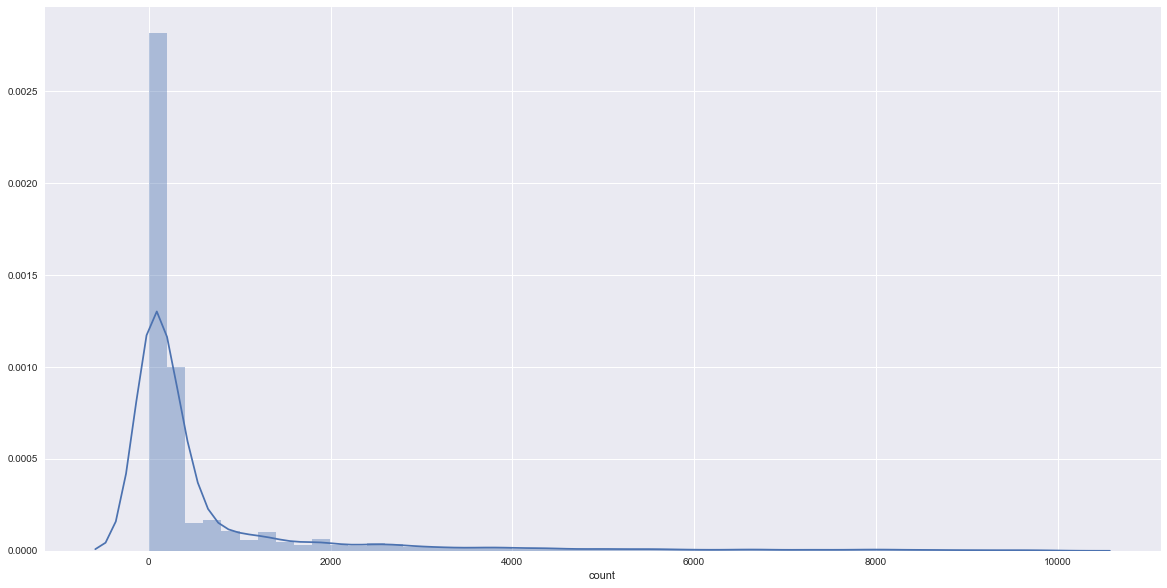

In [239]:
plt.figure(figsize=(20,10))
sns.distplot(all_middle_resources_grouped_1['count'])
sns.plt.show()

<div class="alert alert-success">
The majority of our resources seems to be present around 1000-2000 times in our paths. Having some outliners, the zone around 1000-2000 is note really visible in the graph below; so we'll plot only this zone below.
</div>

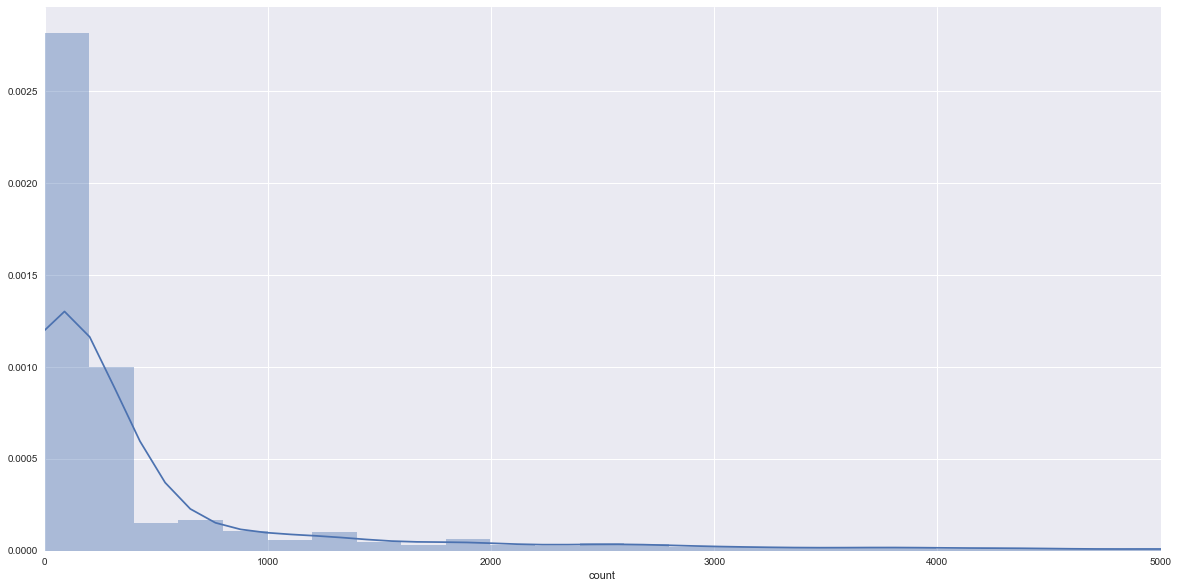

In [240]:
plt.figure(figsize=(20,10))
sns.distplot(all_middle_resources_grouped_1['count']).set(xlim=(0, 5000))
sns.plt.show()

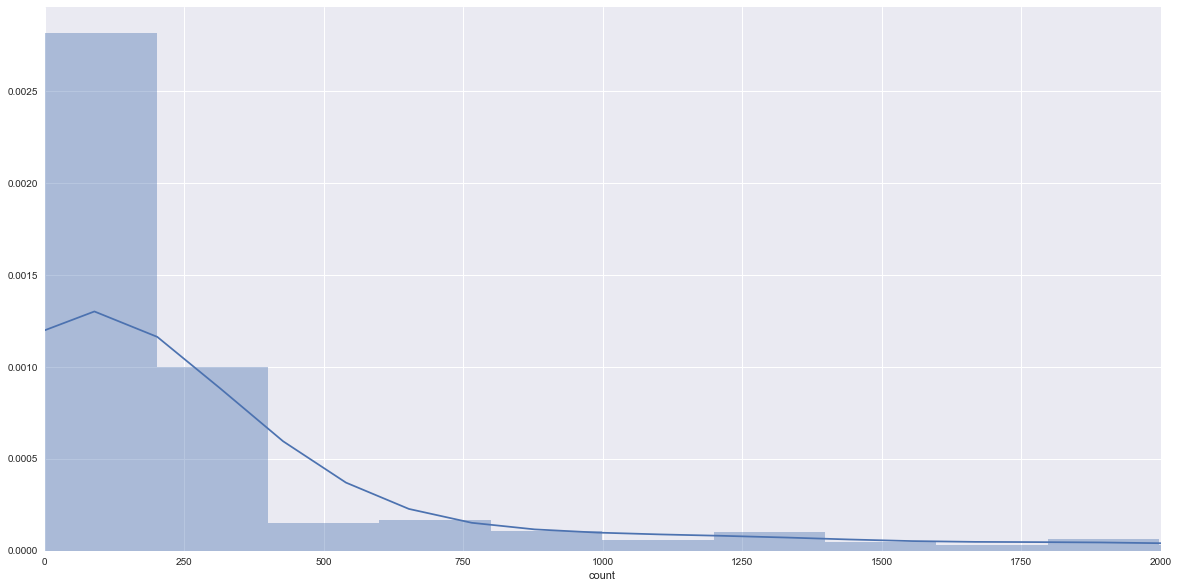

In [241]:
plt.figure(figsize=(20,10))
sns.distplot(all_middle_resources_grouped_1['count']).set(xlim=(0, 2000))
sns.plt.show()

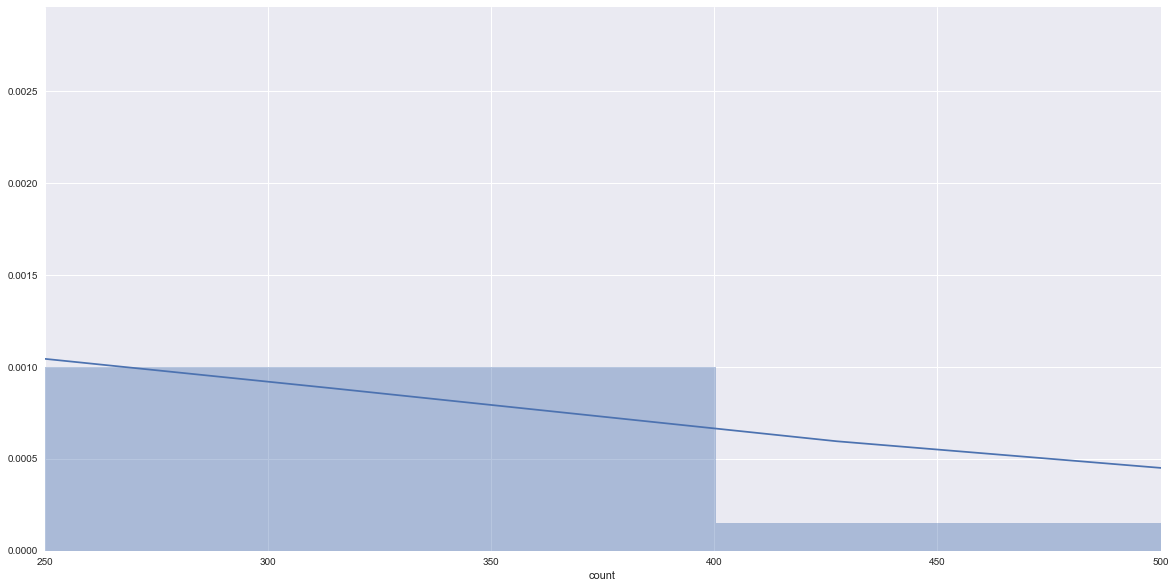

In [242]:
plt.figure(figsize=(20,10))
sns.distplot(all_middle_resources_grouped_1['count']).set(xlim=(250, 500))
sns.plt.show()

 <div class="alert alert-success">
Looking this plot we can note that the most of the resources is present around 1800 times in our paths. We started using this value as threshold to filter out all too generic resources that rapresent noise. Howerver this threshold was too high and some noise remained in our data, so we have set 500 as threshold.
</div>

In [243]:
bad_resources = list(all_middle_resources_grouped_1[all_middle_resources_grouped_1['count']>400]['resource'])

In [244]:
def isBad(x,arr_names,bad_resources):
    for n in arr_names:
        if x[n] in bad_resources:
            return False
    return True

In [245]:
trace = 0

In [246]:
df_paths_rm_outliers= my_paths[my_paths.apply(lambda x: isBad(x,columns[2:-2:2],bad_resources), axis=1)].drop_duplicates()

In [247]:
print("Total number of paths: ",len(df_paths_rm_outliers))

Total number of paths:  1757


<div class="alert alert-success">
As you can see, we have drastically reduced the total number of paths. 
</div>

In [75]:
df_paths_rm_outliers.to_csv("artists_pois_paths_rm_outliers.csv",index=False)

In [248]:
df_paths_rm_outliers.to_pickle("df_paths_rm_outliers")

In [112]:
my_paths.to_pickle("my_paths")

### 3 - THIRD FILTERING STEP: PRESERVE ONLY SHORTEST PATHS

<div class="alert alert-success">
Here we want to save only the shortest path between an artist and a POI. A shorter path doesn't mean certainly a better one. However the majority of our paths is really long (6 of depth), so this step is useful to delete all informations repeated.
Let's suppose to have these 2 paths (the letters rappresent the resources): 
<ul>
  <li>A->B->D->E->F</li>
  <li>A->B->C->D->E->F</li>
</ul>
We want to preserve only the first one.
</div>

In [3]:
my_paths=pd.read_pickle("my_paths").drop_duplicates()
columns = my_paths.columns

In [57]:
paths_np = my_paths.as_matrix()

In [58]:
filtered_np_as_dict = {}
for count,line in enumerate(paths_np):
    entity = line[0]
    poi = line[-1]
    key=entity+poi
    #print(count)
    if not key in filtered_np_as_dict:
        #print(1)
        filtered_np_as_dict[key] = [line]
    else:
        #print(2)
        oldlines=filtered_np_as_dict[key]
        #print(oldlines)
        for i,ol in enumerate(oldlines):
            #print (ol)
            len1 = len([value for value in ol if type(value)!=float])
            len2 = len([value for value in line if type(value)!=float])
            if len1 > len2:
                #print('a')
                filtered_np_as_dict[key][i] = line
            elif len1 == len2:
                #print('b')
                filtered_np_as_dict[key] = oldlines +[line]

In [59]:
values_filtered_np_as_dict=filtered_np_as_dict.values()
paths_filtered = pd.DataFrame(np.array([j for i in values_filtered_np_as_dict for j in i]),columns=columns).drop_duplicates()

In [82]:
len(paths_filtered)

27931

In [83]:
paths_filtered.to_pickle('paths_filtered')

<div class="alert alert-success">
The table above shows a sample of paths that we obtained after 3 filtering steps. There are some bad paths; however some interesting paths start appearing as at line 16.
</div>

In [62]:
columns =paths_filtered.columns

In [ ]:
paths_filtered['path_lenght']= paths_filtered.apply(lambda row: 1+len([row[col] for col in columns[2:-2:2] if type(row[col])!=float]),axis=1)
paths_filtered = paths_filtered.sort_values('path_lenght', ascending=True).drop_duplicates()

In [64]:
paths_filtered_np = paths_filtered.as_matrix()

In [ ]:
paths_filtered_with_generality_np = []
for i,path in enumerate(paths_filtered_np):
    if i % 1000 == 0:
        print (i)
    total_count = 0
    full_cells = 0
    for o in path[2:-2:2]:
        if type(o) != float:
            total_count += int(all_middle_resources_grouped_1[all_middle_resources_grouped_1['resource']==o]['count'])
            full_cells += 1
    new_path = np.append(path, total_count/full_cells)
    paths_filtered_with_generality_np.append(new_path)

In [ ]:
from math import log
def getScore(dist,generality,min_generality,max_generality,max_dist,a=0.3,b=0.7):
    normalized_generality = (generality -min_generality)/(max_generality-min_generality)
    return 1- a*(log(dist + 2)/log(2*(max_dist-1))) - b*normalized_generality

paths_filtered_with_score_np = []
min_generality = np.min(np.transpose(np.array(paths_filtered_with_generality_np))[-1])
max_generality = np.max(np.transpose(np.array(paths_filtered_with_generality_np))[-1])
max_dist = np.max(np.transpose(np.array(paths_filtered_with_generality_np))[-2])
for i,path in enumerate(paths_filtered_with_generality_np):
    if i % 1000 == 0:
        print (i)
    total_count = 0
    full_cells = 0
    generality = path[-1]
    dist = path[-2]
    score = getScore(dist,generality,min_generality,max_generality,max_dist,a=0.3,b=0.7)
    new_path = np.append(path[:-2], score)
    paths_filtered_with_score_np.append(new_path)
    #print(paths_filtered_with_score_np)


In [77]:
paths_filtered_with_score_np_t = list(np.transpose(np.array(paths_filtered_with_score_np)))
scores = paths_filtered_with_score_np_t[-1]
normalized_scores = (scores - np.mean(scores))/np.std(scores)
paths_filtered_with_score_np_final = np.transpose(np.array(paths_filtered_with_score_np_t+[normalized_scores]))

In [ ]:
new_cols = ['entity', 'p1', 'o1', 'p2', 'o2', 'p3', 'o', 'p3_', 'o2_', 'p2_', 'o1_','p1_', 'poi','score','gaussian_score']
paths_filtered_with_score = pd.DataFrame(paths_filtered_with_score_np_final,columns=new_cols).sort_values('score', ascending=False).drop_duplicates()


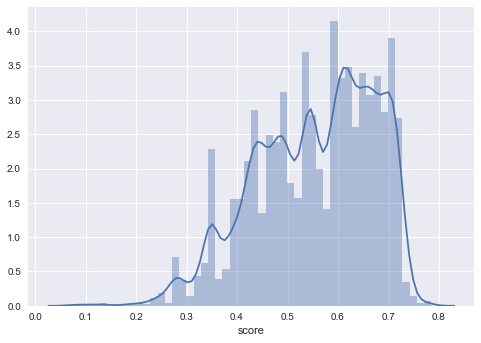

In [79]:
sns.distplot(paths_filtered_with_score['score'])
plt.show()

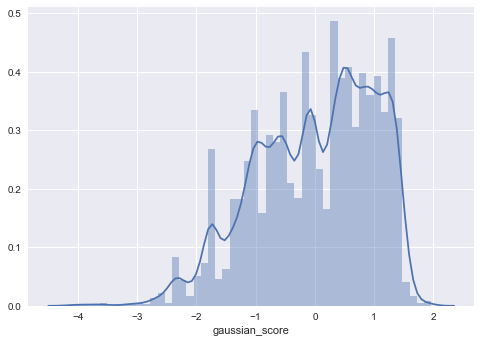

In [80]:
sns.distplot(paths_filtered_with_score['gaussian_score'])
plt.show()

In [81]:
paths_filtered_with_score.to_pickle('paths_filtered_with_score')

In [97]:
final_pois = list(pd.read_csv(input_directory+'dbpedia_match_nogeo_distinct.csv')['dbpedia_uri'].drop_duplicates())

In [84]:
input_directory = "input_files/"
import json
with open(input_directory+'artists_tracks_start.json','r') as f:
    df_artist_spotify  = json.load(f).keys()
pickle.dump(list(df_artist_spotify), open( "df_artist_spotify", "wb" ) )
with open("df_artist_spotify",'rb') as f:
    df_artist_spotify = pickle.load(f)
    


In [103]:
paths_sportify = paths_filtered_with_score[paths_filtered_with_score['entity'].isin(df_artist_spotify)]

In [107]:
paths_final = paths_sportify[paths_sportify['poi'].isin(final_pois)]

In [116]:
paths_final.columns = ['artist']+[c for c in paths_final.columns[1:]]

In [119]:
paths_final.to_csv('myPaths.csv',index=False)